In [1]:
%matplotlib inline
from functools import reduce
import pandas as pd
import os, fnmatch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib as mpl
import pickle as pkl


In [2]:
def readDat(files, path, time_zone, from_wrf = True):
    """
    Read time series csv files for each station code from a specific path
    
    Parameters
    ----------
    files : str list
        name of csv files
    path  : str
        path location
    time_zone : str
        for instance 'America/Sao_Paulo'
    
    Returns
    -------
    Pandas DataFrame
    """
    Data = pd.DataFrame()
    
    if from_wrf:
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize("UTC")
        Data.loc[:,'local_date']=Data['date'].dt.tz_convert(time_zone)
        return Data
    
    else: # observations
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S')
        Data.rename(columns={'date':'local_date'}, inplace = True)
        Data.loc[:,'local_date']=Data['local_date'].dt.tz_localize(time_zone)
        return Data

def subplots(df,pol,ylabel,xlabel,suffixes,legend, size, n_yticks, n_xticks,filename,alpha,lw,markersize,labelsize, by):
    """
    Return lineplot subplots by station only completed data to be compared.
    
    Parameters
    ----------
    df       : pandas DataFrame with datetime as index
               time series with colnames as station and meteorological and air quality parameters
    pol      : str
               air quality parameter, for instance, pol = 'o3'
    ylabel   : str
    xlabel   : str
    suffixes : list of two strings, for instance suffixes = ['_obs','_mod']
    legend   : list of two strings
    size     : tuple, default size = (6,8)
    n_yticks : int
               Number of yaxis labels
    n_xticks : int
               Interval number of xaxis labels               
    path     : str
               path location where the figure will be located
    name     : str
               suffix name of figure
    alpha    : float between 0 and 1. Default 0.7
    lw       : int
    markersize : int
    labelsize : int
    by       : str
               subplots by specific name based column names
    
    Returns
    -------
    Figure exported as pdf plot in a specific path
    
    """
    df_1 = df[['station','type',pol+suffixes[0],pol+suffixes[1]]].dropna()
    locs = list(df_1.sort_values(by=by,ascending=True)[by].unique())
    
    fig, ax = plt.subplots(df_1[by].nunique(),
                           figsize=size, 
                           sharex=True, sharey=True,
                           gridspec_kw={'hspace':0.4}, 
                           subplot_kw={'ylabel':ylabel,'xlabel':xlabel})
    for i in range(df_1[by].nunique()):
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[0]].\
        plot(ax=ax[i],color='k', marker='.',linestyle='none',
             markersize=markersize, label=legend[0])
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[1]].\
        plot(ax=ax[i],color='g', marker='o',markersize=markersize,markeredgecolor='none',linestyle='none',lw=lw, alpha=alpha, label=legend[1])
        ax[0].xaxis.set_major_formatter(md.DateFormatter('%a-%d'))
        ax[0].xaxis.set_major_locator(md.DayLocator(np.arange(0,31,n_xticks)))
        ax[0].xaxis.set_minor_locator(md.MonthLocator())
        ax[0].xaxis.set_minor_formatter(md.DateFormatter('\n\n\n%b-%y'))
        ax[i].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
        ax[i].tick_params(axis='both', which='minor', labelsize=labelsize)
        ax[i].tick_params(axis='both', labelsize=labelsize)
        ax[i].set_xlabel(xlabel)
        ax[i].set_title(locs[i],size=8, loc='left')
        if i == len(df_1[by].unique())-1:
            ax[i].legend(fontsize=7)
    fig.savefig(filename+'_subplot_'+pol+'.pdf',bbox_inches='tight', facecolor='w')



# Evaluation of Simulation Results for October 2018
Two types of measured data are air quality and meteorological parameters from CETESB stations. Only IAG station belongs to São Paulo University, located in Água Funda, and measures meteorological parameters. The evaluation period corresponds to October 1-31, 2018. Measured data has time series in hourly resolution.

Some stations located close to coastal zone were not included as part of statistical evaluation, which are:

* Santos
* Santos-Ponta da Praia
* Cubatão-Centro
* Cubatão-Vale do Mogi
* Cubatão-V.Parisi

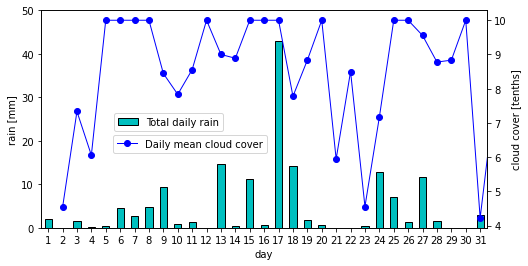

In [3]:
met_iag = pkl.load(open('../2_Met/IAG/iag_met.pkl',"rb")).drop(['name','code'],axis=1)
met_iag = met_iag.loc['2018-10':,:]
met_iag['day'] = met_iag.index.day
met_iag = met_iag[['day','rr','cc']].groupby('day').agg({'rr':'sum','cc':'mean'})
fig, ax = plt.subplots(figsize=(8,4))
plot_rr = met_iag.rr.plot(kind='bar', rot=0, color='c', edgecolor='k', label='Total daily rain', legend=True)
ax.legend(bbox_to_anchor=(0.42, 0.55))
ax2 = ax.twinx()
met_iag.cc.plot(rot=0,ax=ax2, lw=1, color='b',marker='o',label='Daily mean cloud cover', legend=True)
ax2.legend(bbox_to_anchor=(0.15, 0.45))
ax.set_ylabel('rain [mm]')
ax.set_ylim(0,50)
ax2.set_ylabel('cloud cover [tenths]')
#def highlight(indices,ax):
#    i=0
#    while i<len(indices):
#        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor='0', edgecolor='none', alpha=.2)
#        i+=1
#highlight([13,14], plot_rr)
fig.savefig('../4_Draft_Report/Dissertation/fig/rain_cc_oct18.pdf', bbox_inches='tight', facecolor='w')

In [4]:
stations = pd.read_csv('../1_ObsData/stations.csv')
not_stations = ['Santos',
                'Santos-Ponta da Praia',
                'Cubatão-Centro',
                'Cubatão-Vale do Mogi',
                'Cubatão-V.Parisi']
stations = stations.loc[(~stations.name.isin(not_stations)) & \
                        (stations.domain =='d02')]\
            .drop('domain', axis=1).sort_values(by='code')
stations.index =stations.code
stations

,name,lat,lon,code,type,abb
code,,,,,,
0,IAG,-23.651200,-46.622400,0,Forest preservation,IAG
63,Santana,-23.505993,-46.628960,63,Urban,Stna
64,Santo Amaro,-23.654977,-46.709998,64,Urban,SAm
65,Mauá,-23.668549,-46.466000,65,Urban,Maua
67,Sorocaba,-23.502427,-47.479030,67,Regional urban,Srcb
72,Parque D.Pedro II,-23.544846,-46.627676,72,Urban,PDPII
73,Congonhas,-23.616320,-46.663466,73,Urban,Cng
83,Ibirapuera,-23.591842,-46.660688,83,Urban park,Ibir
85,Mooca,-23.549734,-46.600417,85,Urban,Mca


In [5]:
 print(f"""
 We have {stations.name.nunique()} stations with hourly measurements obtained to compared with
 WRF-Chem results. Also, there are {stations.type.nunique()} stations type, which are:
 {list(stations.type.unique())}.
 """)


We have 57 stations with hourly measurements obtained to compared with
WRF-Chem results. Also, there are 5 stations type, which are:
['Forest preservation', 'Urban', 'Regional urban', 'Urban park', 'Industry'].



## October, 2018

WRF-Chem model results correspond to second domain with spatial resolution of 3 km $\times$ 3 km. The results were obtained using NALROM as chemical boundary conditions and NCEP Final Analysis from GFS as meteorology initial and boundary conditions. To model all hours of September, model was reinitializated each 5 days with one day of spin-up was done, methodology suggested by Ritter (2013). We use the function `readDat` to import and merge WRF-Chem data by station name, named as `data`. O$_3$ 8 hours rolling mean was calculated and named as `rollo3`. Hourly mean by station type was also calculated and named as `by_type`.

In [6]:
# Import and join Obs and Mod data
#filename = 'alldata_Sep18_not14_15.pkl' # as pandas DataFrame
#fname_1 = 'Obs_dic_not14_15.pickle'     # as Dictionary
#fname_2 = 'Mod_dic_not14_15.pickle'     # as Dictionary
filename = 'alldata_Oct18.pkl'
#fname_1 = 'Obs_dic_oct18.pickle'
#fname_2 = 'Mod_dic_oct18.pickle'

if os.path.exists(filename) is False:
    # Meteorological parameters observations
    Dir = '../1_ObsData/OCT18/'
    f18 = fnmatch.filter(os.listdir(Dir), 'all_met*.csv')
    metObs = readDat(f18, path = Dir, time_zone='America/Sao_Paulo',from_wrf = False)

    # Air quality parameters observations
    f18 = fnmatch.filter(os.listdir(Dir), 'all_photo*.csv')
    aqObs = readDat(f18, path = Dir, time_zone='America/Sao_Paulo', from_wrf = False)
    Obs = pd.merge(metObs, aqObs)
    Obs['nox']=Obs.no+Obs.no2
    #start_remove = pd.to_datetime('2018-09-14').tz_localize('America/Sao_Paulo')
    #end_remove = pd.to_datetime('2018-09-16').tz_localize('America/Sao_Paulo')
    #Obs = Obs.loc[(Obs.local_date < start_remove) | (Obs.local_date > end_remove)]
       # As dictionary
    Obs_dic = {}
    for code in stations.code:
        Obs_dic[stations.name[stations.code == code].values[0]] = (Obs[Obs.code==code])

    # WRF-Chem output re-initialization with one day of spin-up
    Dir = '../3_Results/Y2018/wrfout_exp10/oct18/'
    f18 = fnmatch.filter(os.listdir(Dir), '*FIN_d02*')

    Mod = readDat(f18, path = Dir,time_zone='America/Sao_Paulo', from_wrf=True)
    Mod.rename(columns={'name':'station'})
    Mod = Mod[['local_date','code','station','type','tc','rh','ws','wd','o3','no','no2','co']]
    Mod['nox'] = Mod.no+Mod.no2
      # As dictionary
    Mod_dic = {}
    for code in stations.code:
        Mod_dic[stations.name[stations.code == code].values[0]] = (Mod[Mod.code==code])

    data = pd.merge(Obs, Mod,
                    on=['local_date','station','code','type'],
                    suffixes=('_obs', '_mod'))
    # to pickle
    data.to_pickle(filename)
    #pkl.dump(Obs_dic, open(fname_1, "wb"))
    #pkl.dump(Mod_dic, open(fname_2, "wb"))

else:
    data = pd.read_pickle(filename)
    #Obs_dic = pkl.load(open(fname_1, "rb"))
    #Mod_dic = pkl.load(open(fname_2, "rb"))

# Rolling 8 hour mean
o3 = data[['local_date','station','type', 'o3_obs','o3_mod']].set_index('local_date')
roll_o3 = {}
rollo3 = pd.DataFrame()
for i in o3.station.unique():
    roll_o3[i] = (o3[o3.station == i].rolling(window=8).mean()[['o3_obs','o3_mod']])
    roll_o3[i]['station'] = (i)
    roll_o3[i]['type'] = (o3[o3.station == i].type)
    df = roll_o3[i]
    rollo3 = pd.concat([rollo3,df])
    rollo3['day'] = rollo3.index.day
    MDA8 = rollo3.groupby(['day','station','type']).max().reset_index().dropna()

# Hourly mean by station type
by_type = data.groupby(['local_date','type']).mean().reset_index().drop(['code'], axis=1)

In [7]:
data

,local_date,tc_obs,rh_obs,sr,ws_obs,wd_obs,code,station,type,o3_obs,...,nox_obs,tc_mod,rh_mod,ws_mod,wd_mod,o3_mod,no_mod,no2_mod,co_mod,nox_mod
0,2018-10-01 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,NaN,...,NaN,20.661896,86.530080,1.541756,85.27135,0.228771,40.267452,86.496520,0.370939,126.763972
1,2018-10-01 01:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,...,NaN,20.298431,85.678510,0.929507,78.46851,1.224506,25.524082,83.565414,0.312542,109.089496
2,2018-10-01 02:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,...,NaN,20.602875,81.754840,1.865919,358.41916,22.926458,3.072827,56.368770,0.211802,59.441597
3,2018-10-01 03:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,1.0,...,NaN,20.698425,81.190170,3.157998,340.84323,19.450043,3.700394,53.608170,0.209334,57.308564
4,2018-10-01 04:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,2.0,...,NaN,20.787872,79.799995,2.850628,338.95016,15.948642,4.561612,52.489902,0.204560,57.051514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41491,2018-10-31 16:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,...,NaN,30.130219,44.682205,1.382181,222.75276,125.126820,2.873182,28.353329,0.217417,31.226511
41492,2018-10-31 17:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,...,NaN,28.074524,53.944267,2.380849,133.11775,126.318726,1.487054,35.147415,0.138394,36.634469
41493,2018-10-31 18:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,...,NaN,26.210876,60.907430,3.972509,171.35718,117.564926,0.884245,52.086742,0.312060,52.970987
41494,2018-10-31 19:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,...,NaN,24.757294,65.784256,2.411869,169.53596,110.101440,0.124971,55.030895,0.301282,55.155866


### Statistical Evaluation
The `Mod_statistic` script was built by Mario Gavidia and with few changes done by me. Here you see the follow functions:
```python
* aq_Stats(data, polls=['o3', 'no', 'no2', 'co', 'tc', 'rh'])
* met_stats(data,mets=['tc','rh','ws','wd'])
* r_pearson_sig(n, r, alpha, deg_free = 2)
* r_pearson_confidence_interval(n, r, alpha)
```

Statistical benchmarks from Emery et al. (2017) were used to evaluate surface ozone (1 hour or mean values of the daily maximum 8 h average (MDA8) ozone) obtained from the WRF-Chem model:

Parameter |   Goal   |  Criteria  |
--------- |----------|----------- |
NMB | < $\pm$5% | < $\pm$15%
NME | < 15% | < 25%
r | > 0.75 | > 0.5

Furthermore, statistical benchmarks from Monk et al. (2019) were used to evaluate meteorology results for complex terrain:

Parameter        | Criteria (complex terrain)
----------       | --------
Temperature      | MB  $\leq\pm$ 1 K
                 | MAGE $\leq$ 3.0
                 | IOA $\geq$ 0.8
Wind speed       | RMSE $\leq$ 2.5
                 | MB   $\leq \pm$ 1.5 ms$^{-1}$
                 | IOA $\geq$ 0.6
Wind direction   | MB < $\pm$ 10º
                 | ME $\leq$ 55º
Relative Humidity| MB < $\pm$10%
                 | MAGE < 20%
                 | IOA $\geq$ 0.6

Global statistical results by hour are showed in the following table.

In [8]:
import mod_stats as ms
gl_sta_oct18 = ms.aq_stats(data,
             polls=['o3', 'no', 'no2', 'nox','co']).round(2).T
gl_sta_oct18

,o3,no,no2,nox,co
n,25961.00,24033.00,24033.00,24033.00,12120.00
MB,13.19,-4.13,1.36,-2.77,-0.31
MAGE,22.50,8.73,15.42,22.97,0.33
RMSE,29.42,21.90,21.77,37.43,0.44
NMB,31.73,-48.06,5.79,-8.64,-61.77
NME,54.11,101.67,65.68,71.63,64.66
IOA,0.76,0.31,0.65,0.56,0.44
r,0.64,0.16,0.42,0.34,0.17
Mm,54.78,4.46,24.84,29.30,0.19
Om,41.58,8.59,23.48,32.07,0.51


In [10]:
gl_sta_sep18 = pd.read_pickle("gl_stat_sep18.pkl")
gl_sta = pd.concat([gl_sta_sep18,gl_sta_oct18],axis=1,keys=['Sep. 2018', 'Oct. 2018'])
gl_sta

Sep. 2018                                        Oct. 2018            \
            o3        no       no2       nox       co        o3        no   
n     23849.00  21631.00  21631.00  21631.00  9805.00  25961.00  24033.00   
MB        9.35     -0.61      4.03      3.42    -0.26     13.19     -4.13   
MAGE     24.01     10.47     18.29     27.67     0.29     22.50      8.73   
RMSE     30.08     23.74     25.74     43.55     0.40     29.42     21.90   
NMB      19.28     -7.22     15.36      9.87   -52.30     31.73    -48.06   
NME      49.52    124.15     69.66     79.79    59.31     54.11    101.67   
IOA       0.80      0.46      0.62      0.58     0.45      0.76      0.31   
r         0.67      0.25      0.39      0.34     0.19      0.64      0.16   
Mm       57.83      7.82     30.28     38.11     0.23     54.78      4.46   
Om       48.48      8.43     26.25     34.68     0.49     41.58      8.59   
Msd      37.74     17.42     25.40     38.52     0.12     33.25      8.53   
Osd      31.38     20.99     19.99     36.92     0.31     27.50     21.16   

                                    
           no2       nox        co  
n     24033.00  24033.00  12120.00  
MB        1.36     -2.77     -0.31  
MAGE     15.42     22.97      0.33  
RMSE     21.77     37.43      0.44  
NMB       5.79     -8.64    -61.77  
NME      65.68     71.63     64.66  
IOA       0.65      0.56      0.44  
r         0.42      0.34      0.17  
Mm       24.84     29.30      0.19  
Om       23.48     32.07      0.51  
Msd      20.78     26.65      0.08  
Osd      19.47     36.86      0.32

In [11]:
print(gl_sta.to_latex(caption='Global statistical results for air quality parameter', label='tab: gl_st'),
      file=open('../4_Draft_Report/Dissertation/table/gl_sta.tex','a'))

In [12]:
by = 'type'
sites = list(data[[by,'o3_obs','o3_mod']].dropna().sort_values(by=by,ascending=True)[by].unique())
o3_stats = {}
o3sta_df = pd.DataFrame()
for i in sites:
    o3_stats[i] = (ms.aq_stats(data[data[by].isin([i])],polls=['o3']))
    o3_stats[i][by] = (i)
    df = o3_stats[i]
    o3sta_df = pd.concat([o3sta_df,df]).round(2)
o3sta_df = o3sta_df.sort_values(by='r', ascending=False).loc['o3']
o3sta_oct18 = o3sta_df.set_index('type').T.rename(columns={'Industry':'Ind',
                                                        'Forest preservation':'F. pre.',
                                                        'Regional urban':'R. urb.',
                                                        'Urban park': 'U. park',
                                                        'Urban':'Urb'})
o3sta_oct18 = o3sta_oct18[['F. pre.','Urb','U. park','Ind','R. urb.']]
o3sta_oct18

type,F. pre.,Urb,U. park,Ind,R. urb.
n,709.00,12383.00,2663.00,706.00,9500.00
MB,4.46,10.33,4.55,19.91,19.50
MAGE,22.11,21.25,21.03,28.69,24.11
RMSE,28.38,28.46,27.69,35.10,30.71
NMB,10.75,27.77,11.52,45.85,40.85
NME,53.28,57.12,53.21,66.05,50.50
IOA,0.74,0.77,0.80,0.76,0.69
r,0.60,0.66,0.67,0.69,0.60
Mm,45.97,47.52,44.07,63.34,67.25
Om,41.51,37.20,39.52,43.43,47.74


In [13]:
o3sta_sep18 = pd.read_pickle("o3sta_sep18.pkl")
o3_sta = pd.concat([o3sta_sep18,o3sta_oct18],axis=1,keys=['Sep. 2018', 'Oct. 2018'])
o3_sta

Sep. 2018                                     Oct. 2018            \
type   F. pre.       Urb  U. park     Ind  R. urb.   F. pre.       Urb   
n       636.00  11314.00  2205.00  637.00  9057.00    709.00  12383.00   
MB        0.51      4.03    -1.68   17.20    18.75      4.46     10.33   
MAGE     24.44     23.27    23.35   27.23    24.83     22.11     21.25   
RMSE     30.64     29.54    29.25   32.52    30.70     28.38     28.46   
NMB       1.02      8.96    -3.49   33.95    35.57     10.75     27.77   
NME      48.90     51.75    48.54   53.75    47.11     53.28     57.12   
IOA       0.81      0.80     0.82    0.85     0.76      0.74      0.77   
r         0.72      0.68     0.69    0.80     0.69      0.60      0.66   
Mm       50.49     49.00    46.43   67.85    71.45     45.97     47.52   
Om       49.98     44.97    48.11   50.65    52.70     41.51     37.20   
Msd      43.91     39.91    40.11   36.60    28.55     34.73     34.90   
Osd      28.98     28.95    31.62   46.19    32.56     24.68     25.90   

                                
type  U. park     Ind  R. urb.  
n     2663.00  706.00  9500.00  
MB       4.55   19.91    19.50  
MAGE    21.03   28.69    24.11  
RMSE    27.69   35.10    30.71  
NMB     11.52   45.85    40.85  
NME     53.21   66.05    50.50  
IOA      0.80    0.76     0.69  
r        0.67    0.69     0.60  
Mm      44.07   63.34    67.25  
Om      39.52   43.43    47.74  
Msd     36.53   30.54    25.17  
Osd     27.90   39.49    27.37

In [14]:
print(o3_sta.to_latex(caption='Statistical results for surface ozone', label='tab: o3_sta'),
      file=open('../4_Draft_Report/Dissertation/table/o3_sta.tex','w'))

In [9]:
sites = list(data[['station','o3_obs','o3_mod']].dropna().sort_values(by='station',ascending=True).station.unique())
o3_stats = {}
o3sta_df = pd.DataFrame()
for i in sites:
    o3_stats[i] = (ms.aq_stats(data[data.station.isin([i])],polls=['o3']))
    o3_stats[i]['station'] = (i)
    df = o3_stats[i]
    o3sta_df = pd.concat([o3sta_df,df]).round(2)
o3sta_df = o3sta_df.sort_values(by='r', ascending=False).loc['o3']
o3sta_df['abb'] = [stations[stations.name == i].abb.values[0] for i in o3sta_df.station]
o3sta_df['type'] = [stations[stations.name == i].type.values[0] for i in o3sta_df.station]
o3sta_df #[(o3sta_df.n > 600) & (o3sta_df.NME < 60) & (o3sta_df.NMB < 40)]

,n,MB,MAGE,RMSE,NMB,NME,IOA,r,Mm,Om,Msd,Osd,station,abb,type
o3,679,11.97,19.30,25.95,36.61,59.03,0.80,0.74,44.66,32.69,34.13,24.84,Diadema,Dia,Urban
o3,708,8.27,17.54,23.82,20.60,43.68,0.81,0.72,48.44,40.17,32.38,23.70,S.Bernardo-Centro,SBC,Urban
o3,677,4.73,17.85,24.32,11.57,43.66,0.83,0.72,45.61,40.88,34.07,26.86,Itaquera,Itqr,Urban park
o3,690,2.58,18.53,24.53,6.68,47.99,0.83,0.71,41.20,38.62,34.82,26.49,São Caetano do Sul,SCdS,Urban
o3,670,10.09,20.02,27.27,27.54,54.63,0.78,0.70,46.73,36.64,35.52,24.13,S.André-Capuava,SACp,Urban
o3,706,19.91,28.69,35.10,45.85,66.05,0.76,0.69,63.34,43.43,30.54,39.49,Paulínia,Pln,Industry
o3,573,10.29,19.24,24.77,17.54,32.78,0.79,0.68,68.98,58.69,24.40,30.50,Limeira,Lmr,Regional urban
o3,679,13.86,22.21,30.06,48.72,78.04,0.75,0.68,42.32,28.46,36.26,23.86,Santo Amaro,SAm,Urban
o3,554,12.92,22.88,30.42,35.90,63.59,0.76,0.68,48.91,35.99,37.56,25.39,Capão Redondo,CRe,Urban park
o3,709,9.75,22.02,28.86,25.58,57.81,0.79,0.68,47.85,38.10,36.89,28.13,Carapicuíba,Crp,Urban


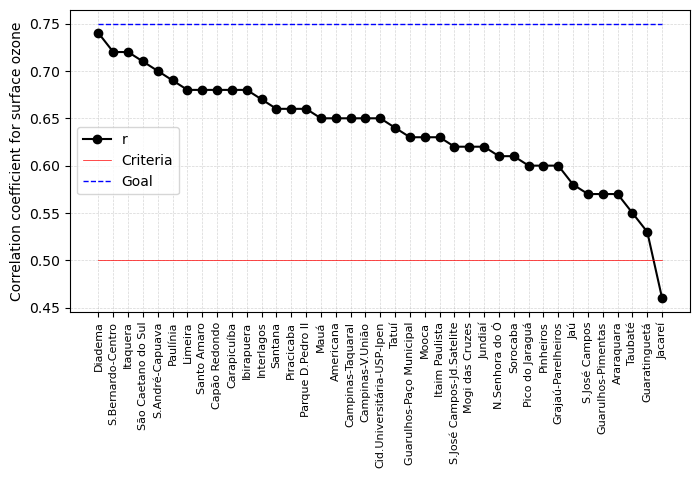

In [10]:
x = o3sta_df.station

fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(x,o3sta_df.r,'ko-', label='r')
plt.plot(x,[0.5 for i in x],'r-', label='Criteria', lw=0.5)
plt.plot(x,[0.75 for i in x],'b--', label='Goal', lw=1)
plt.xticks(x, rotation='vertical', fontsize=8)
plt.ylabel('Correlation coefficient for surface ozone')
plt.legend()
plt.grid(color='0.2', ls='--', lw=0.5,alpha=0.2)
fig.savefig('fig/o3_r_by_station_oct18.pdf',bbox_inches='tight')

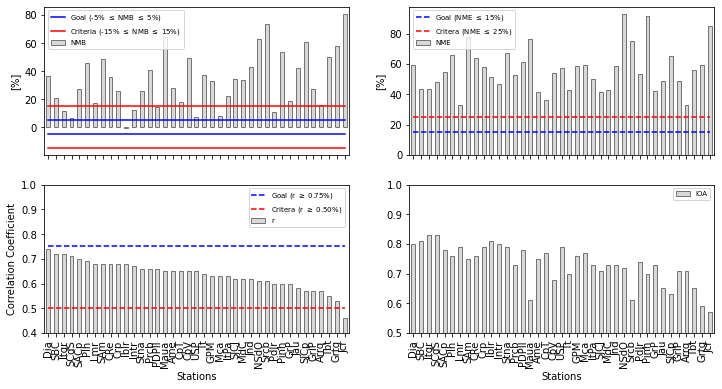

In [11]:
fig, ax = plt.subplots(2,2, figsize=(12,6),sharex=True)
df_stat = o3sta_df

# Script
NMB = df_stat.reset_index(drop=True).set_index('abb')[['NMB']]
NMB['PG'] = 5
NMB['NG'] = -5
NMB['PC'] = 15
NMB['NC'] = -15
# ax[0,0]
NMB.NMB.plot.bar(rot=90,ax=ax[0,0], color='0.7',edgecolor='k', alpha=0.5, label = 'NMB')
NMB['PG'].plot(rot=90,ax=ax[0,0], color='b',label = 'Goal (-5% $\leq$ NMB $\leq$ 5%)')
NMB['NG'].plot(rot=90,ax=ax[0,0], color='b',label = '')
NMB['PC'].plot(rot=90,ax=ax[0,0], color='r',label = 'Criteria (-15% $\leq$ NMB $\leq$ 15%)')
NMB['NC'].plot(rot=90,ax=ax[0,0], color='r',label = '')
ax[0,0].legend(fontsize=7)
ax[0,0].set_ylabel('[%]')

# ax[0,1]
NME = df_stat.reset_index(drop=True).set_index('abb')[['NME']]
NME['G'] = 15
NME['C'] = 25
NME.NME.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[0,1], label='NME')
NME['G'].plot(rot=90,ax=ax[0,1], color='b',linestyle='--', label='Goal (NME $\leq$ 15%)')
NME['C'].plot(rot=90,ax=ax[0,1], color='r',linestyle='--', label='Critera (NME $\leq$ 25%)')
ax[0,1].legend(fontsize=7)
ax[0,1].set_ylabel('[%]')

# ax[1,0]
r = df_stat.reset_index(drop=True).set_index('abb')[['r']]
r['G'] = 0.75
r['C'] = 0.50
r.r.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[1,0])
r['G'].plot(rot=90,ax=ax[1,0], color='b',linestyle='--', label='Goal (r $\geq$ 0.75%)')
r['C'].plot(rot=90,ax=ax[1,0], color='r',linestyle='--', label='Critera (r $\geq$ 0.50%)')
ax[1,0].set_ylabel('Correlation Coefficient')
ax[1,0].set_ylim([0.4,1])
ax[1,0].set_xlabel('Stations')
ax[1,0].legend(fontsize=7)

# ax[1,1]
IOA = df_stat.reset_index(drop=True).set_index('abb')[['IOA']]
IOA.IOA.plot.bar(rot=90, color='0.7', edgecolor='k', alpha = 0.5,ax=ax[1,1], label='IOA')
ax[1,1].legend(fontsize=7)
ax[1,1].set_ylim([0.5,1])
ax[1,1].set_xlabel('Stations')

fig.savefig('fig/o3_stats_oct.pdf',bbox_inches='tight', facecolor='w')

And by station type for MDA8 for surface ozone:

In [12]:
types = list(MDA8.sort_values(by='type',ascending=True).type.unique())
o3_stats_type = {}
o3sta_df = pd.DataFrame()
for i in types:
    o3_stats_type[i] = (ms.aq_stats(MDA8[MDA8.type.isin([i])],polls=['o3']))
    o3_stats_type[i]['type'] = (i)
    df = o3_stats_type[i]
    o3sta_df = pd.concat([o3sta_df,df]).round(2)
o3sta_df

,n,MB,MAGE,RMSE,NMB,NME,IOA,r,Mm,Om,Msd,Osd,type
o3,31,20.47,23.93,29.66,33.45,39.11,0.66,0.55,81.65,61.19,22.48,23.29,Forest preservation
o3,31,10.44,21.24,28.01,12.40,25.23,0.59,0.44,94.62,84.18,17.46,29.05,Industry
o3,422,17.98,22.70,27.21,24.56,31.00,0.60,0.48,91.18,73.20,15.76,22.73,Regional urban
o3,537,22.20,23.41,30.39,38.10,40.18,0.71,0.69,80.47,58.27,27.99,23.46,Urban
o3,118,18.41,21.46,28.29,29.57,34.46,0.74,0.69,80.69,62.27,28.88,25.05,Urban park


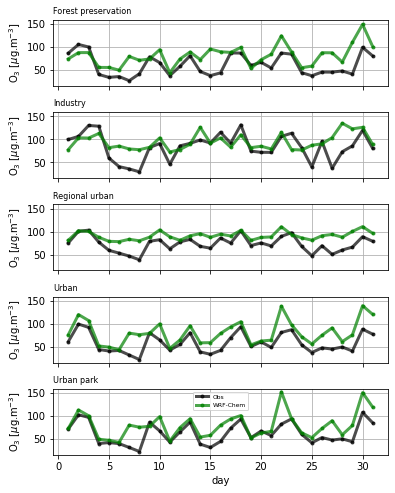

In [13]:
fig, ax = plt.subplots(len(types),
                       figsize=(6,8),
                       sharey=True,
                       sharex=True,
                       subplot_kw={'ylabel':'O$_3$ [$\mu$g.m$^{-3}$]'},
                       gridspec_kw={'hspace':0.4})
for i in range(len(types)):
    MDA8.loc[MDA8.type ==types[i]].groupby(['type','day'])\
    .mean().reset_index().set_index('day')\
    .plot(ax=ax[i], legend=False, grid=True, fontsize=10,
          color='kg', lw=3, marker='.', alpha=.7)
    ax[i].set_title(types[i],size=8, loc='left')
    if i == len(types)-1:
        ax[i].legend(['Obs','WRF-Chem'],fontsize=6)
fig.savefig('fig/MDA8_type_oct18.pdf',bbox_inches='tight', facecolor='w')

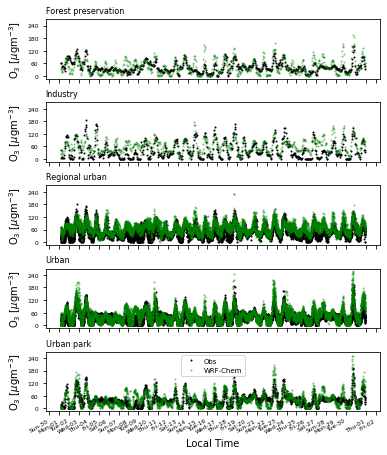

In [17]:
subplots(data.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='o3',
         ylabel='O$_3$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(6,8),
         n_yticks=5,
         n_xticks=1,
         filename='fig/Oct18_type',
         alpha=.5,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='type')

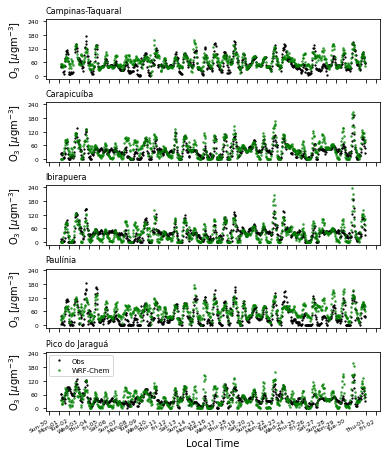

In [18]:
st_names = ['Pico do Jaraguá','Paulínia','Campinas-Taquaral','Carapicuíba','Ibirapuera']
df_plot = data[data.station.isin(st_names)]

subplots(df_plot.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='o3',
         ylabel='O$_3$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(6,8),
         n_yticks=5,
         n_xticks=1,
         filename='fig/Oct18_station',
         alpha=.8,
         markersize=2.5,
         lw=2,
         labelsize=6, 
         by='station')

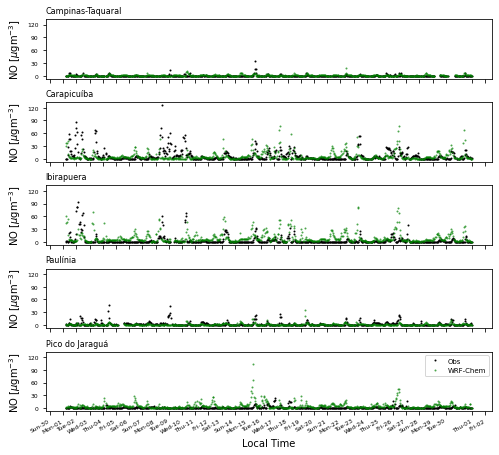

In [19]:
subplots(df_plot.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='no',
         ylabel='NO [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(8,8),
         n_yticks=5,
         n_xticks=1,
         filename='fig/Oct18_station',
         alpha=.7,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='station')

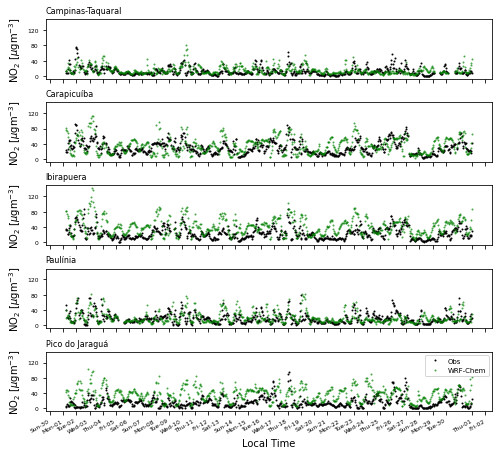

In [20]:
subplots(df_plot.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='no2',
         ylabel='NO$_2$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(8,8),
         n_yticks=5,
         n_xticks=1,
         filename='fig/Oct18_station',
         alpha=.7,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='station')

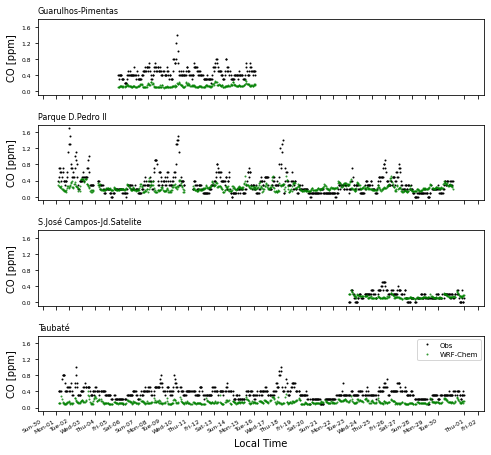

In [21]:
subplots(data.set_index('local_date').dropna(), #[data.station.isin(gr_1)]
         pol='co',
         ylabel='CO [ppm]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(8,8),
         n_yticks=5,
         n_xticks=1,
         filename='fig/Oct18_station',
         alpha=.8,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='station')

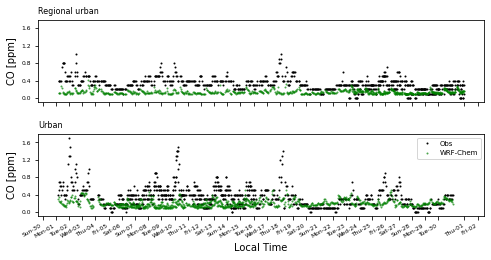

In [22]:
subplots(data.set_index('local_date').dropna(), #[data.station.isin(gr_1)]
         pol='co',
         ylabel='CO [ppm]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(8,4),
         n_yticks=5,
         n_xticks=1,
         filename='fig/Oct18',
         alpha=.7,
         markersize=2,
         lw=2,
         labelsize=6, 
         by='type')